<a href="https://colab.research.google.com/github/omerfarukeker/The-Complete-Journey/blob/master/Omer_eker_the_complete_journey_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Complete Journey Dataset Analysis: Churn Prediction
## by Omer Eker

In this notebook we will make a churn prediction model using a retail dataset. Let's start importing necessary packages for the analysis.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

We will use ***The Complete Journey Dataset from Dunnhumby*** which is available in our Google Drive.

Let's first mount our drive from Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataframe from the .sav file (1.2 GB file size)

In [0]:
import pickle
dfs = pickle.load(open("/content/drive/My Drive/Databases/complete_journey.sav","rb"))

## Exploratory Data Analysis

The dataset consist of **eight** tables in separate .csv files, we will go through six of them which we will use in this notebook. The dataset covers a two year span purchase transactions of **2500** **households**. Also demographics information of households, campaign and coupon redemption informations are available. In the modeling phase we will join these tables to make our final dataset.

1. **Campaign Descriptions** (_campaign_desc.csv_)
2. **Campaigns** (_campaign_table.csv_)
3. **Coupons** (_coupon.csv_)
4. **Coupon Redemptions** (_coupon_redempt.csv_)
5. **Transactions** (_transaction_data.csv_)
6. **Demographics** (_hh_demographic.csv_)

### Campaign Descriptions

Campaign description data is a look up table, containing the start and the end days of each campaign (**30 campaigns in total**). Also it gives which campaign belongs to what category (Type A, B and C).

In [4]:
dfs["campaign_desc"].head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


Let's calculate and visualise how long each campaign lasted within two years period:

* Campaign **No:15** lasts the longest with a staggering 160 days figure, where other campaigns are fairly close to each other ranging from 30 to 70 days
* Average campaign duration is **37** days (median)

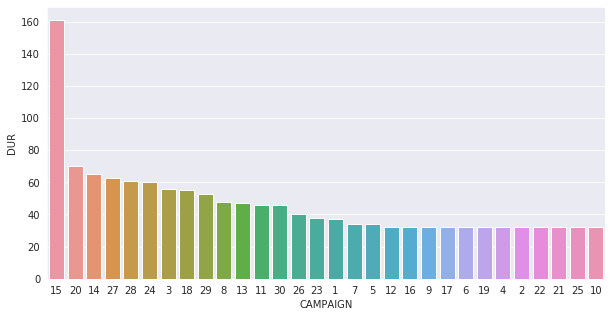

In [5]:
dfs["campaign_desc"]["DUR"] = dfs["campaign_desc"].END_DAY-dfs["campaign_desc"].START_DAY
fig = plt.figure(figsize=(10,5))
sns.barplot(x="CAMPAIGN",y="DUR",data=dfs["campaign_desc"],orient="v",order=dfs["campaign_desc"].sort_values(by="DUR",ascending=False).CAMPAIGN.values)

### Campaign 

Campaign dataset contains identifying information for the marketing campaigns each household participated in.

In [6]:
dfs["campaign_table"].head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Out of 2500 households, **1584** of them received a campaign once, the rest never received a campaign.

In [7]:
total_households = len(dfs["transaction_data"].household_key.unique())
total_households

2500

In [8]:
len(dfs["campaign_table"].household_key.unique())

1584

On the other side, a very small portion of the households received double-digit number of campaigns. We will investigate how this will effect churn rates in the following sections. The barchart below groups the households and shows counts of the group populations.

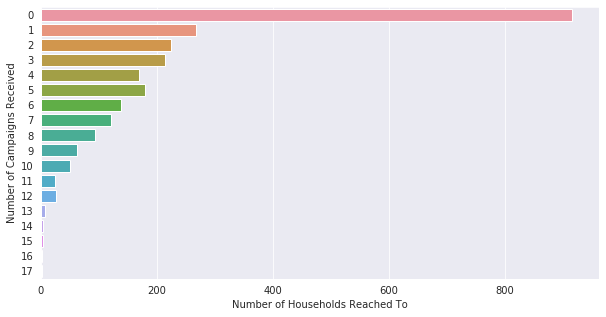

In [9]:
no_of_received_campaigns_per_house = dfs["campaign_table"].household_key.value_counts()
no_of_received_campaigns = no_of_received_campaigns_per_house.value_counts()
no_of_received_campaigns[0] = total_households-len(no_of_received_campaigns_per_house)
no_of_received_campaigns = pd.DataFrame(list(zip(no_of_received_campaigns.index,no_of_received_campaigns)),columns=["Number of Campaigns Received","Number of Households Reached To"]).sort_values(by="Number of Campaigns Received",ascending=True)
plt.figure(figsize=(10,5))
sns.barplot(y="Number of Campaigns Received",x="Number of Households Reached To",data=no_of_received_campaigns,orient="h",order=no_of_received_campaigns["Number of Campaigns Received"])

Graph below gives the most frequent campaigns. Campaign number **18, 13 and 8** being the most frequent ones reaching 1000 and more households each (no campaigns applied to same customer more than once therefore Frequency axis gives unique number of households).

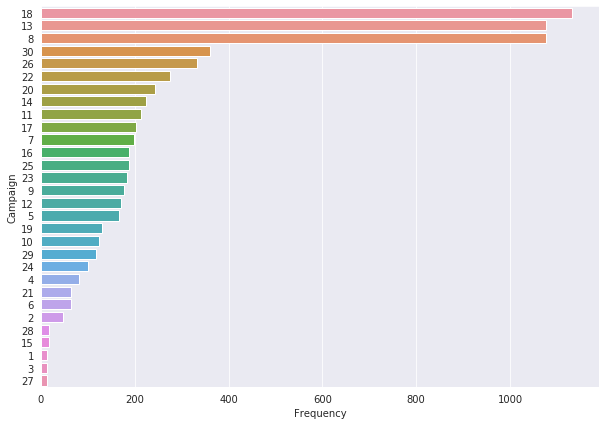

In [10]:
freq_campaigns = pd.DataFrame(list(zip(dfs["campaign_table"].CAMPAIGN.value_counts().index, dfs["campaign_table"].CAMPAIGN.value_counts())),columns=["Campaign","Frequency"])
fig = plt.figure(figsize=(10,7))
sns.barplot(y="Campaign",x="Frequency",data = freq_campaigns,orient="h",order=freq_campaigns.Campaign)

### Coupons

Is a lookup table which lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable

In [11]:
dfs["coupon"].head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


### Coupon Redemptions

Is a data table, ordered by ***household_key***, gives which household redeemed what coupon number. Also the day of the redeem and the campaign number is given for each household.

In [12]:
dfs["coupon_redempt"].head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


Out of 2500 households, only 434 of them (**17%**) redeemed coupons within this period.

In [13]:
len(dfs["coupon_redempt"].household_key.unique())

434

Most frequent campaigns (18, 13 and 8, **all belongs to TypeA**) attracts the most number of redeems as expected. The barchart below gives the number of redeems per campaign.

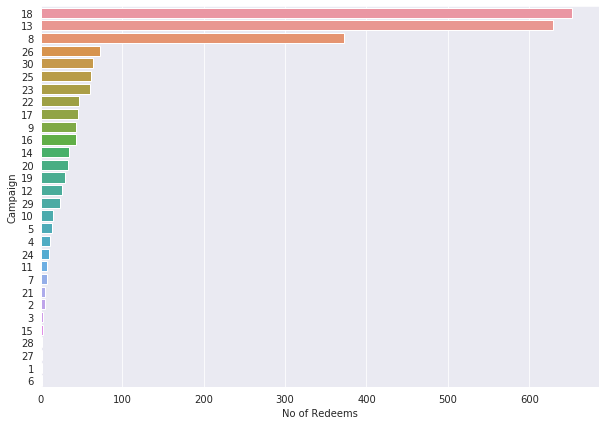

In [14]:
redeem_frequency = pd.DataFrame(list(zip(dfs["coupon_redempt"].CAMPAIGN.value_counts().index, dfs["coupon_redempt"].CAMPAIGN.value_counts())),columns=["Campaign","No of Redeems"])
fig = plt.figure(figsize=(10,7))
sns.barplot(y="Campaign",x="No of Redeems",data = redeem_frequency,orient="h",order=redeem_frequency.Campaign)

The barchart below gives the redeem rates of each campaign in a descending order. Campaign 13 and 18 are clearly have higher redeem rates (~**60%**) as compared to the rest of campaigns.

Based on these results, campaign organisers did well by promoting the right campaigns (13 and 18) more frequently.

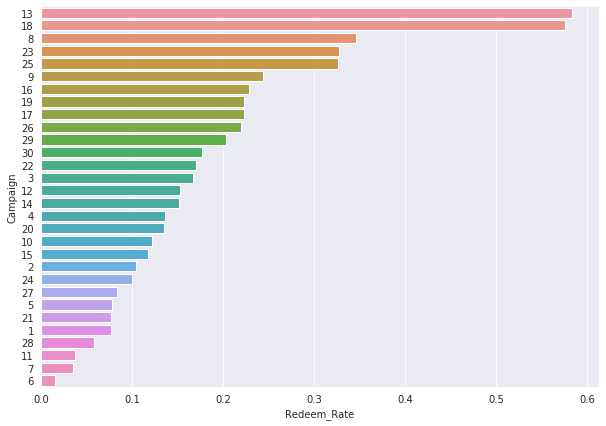

In [15]:
redems_per_camp = dfs["coupon_redempt"].CAMPAIGN.value_counts().sort_values()/dfs["campaign_table"].CAMPAIGN.value_counts().sort_values()
redems_per_camp = pd.DataFrame(list(zip(redems_per_camp.index,redems_per_camp)),columns=["Campaign","Redeem_Rate"]).sort_values(by="Redeem_Rate",ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(y="Campaign",x="Redeem_Rate",data=redems_per_camp,orient="h",order=redems_per_camp.Campaign)

### Transactional Data

Transactional data contains purchase history of each household. It contains the product ID and sales value, store ID and all other transactional features.

In [16]:
dfs["transaction_data"].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


Now lets do some descriptive analysis on the transactional data. First, let's group the data by household numbers:

In [0]:
grouped_sum = dfs["transaction_data"].groupby("household_key").sum()

Average amount of purchase by a household within these two years is:

In [18]:
av_purc = round(dfs['transaction_data'].SALES_VALUE.sum()/len(grouped_sum),1)
av_purc

3223.0

Average total number of products purchased by a household within two years is:

In [19]:
av_tot_prod = round(grouped_sum["QUANTITY"].mean(),1)
av_tot_prod

104274.2

Average total number of unique products purchased by a household within two years is:

In [20]:
av_uniq_prod = round(len(dfs["transaction_data"].groupby(["household_key","PRODUCT_ID"]).sum()["QUANTITY"])/len(grouped_sum),1)
av_uniq_prod

560.6

Average number of store visits per household within two years is:

In [21]:
av_days_visited = round(len(dfs["transaction_data"].groupby(["household_key","DAY"]).count())/len(grouped_sum),1)
av_days_visited

90.2

**Top 20** stores based on total sales amount (USD) is calculated and plotted below. Stores with IDs of **367** and **406** made the most sales amongst 582 stores with over $200,000 each.

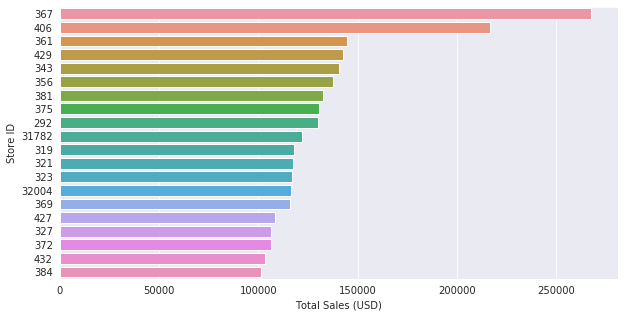

In [22]:
sales_per_store = dfs["transaction_data"].groupby("STORE_ID").sum()["SALES_VALUE"].sort_values(ascending=False)
sales_per_store = pd.DataFrame(list(zip(sales_per_store.index,sales_per_store)),columns=["Store ID","Total Sales (USD)"])
fig_store = plt.figure(figsize=(10,5))
sns.barplot(y="Store ID",x="Total Sales (USD)",data = sales_per_store[:20],order=sales_per_store[:20]["Store ID"],orient="h")

**Top 20** customers based on total purchase amount (USD) is calculated and displayed below. Top customer is with the ID of **1023** who made the most purchases amongst 2500 house holds with almost $40,000.

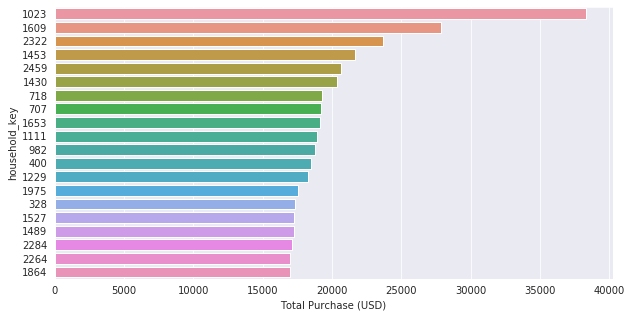

In [23]:
purc_per_cust = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])
fig_store = plt.figure(figsize=(10,5))
sns.barplot(y="household_key",x="Total Purchase (USD)",data = purc_per_cust[:20],order=purc_per_cust[:20]["household_key"],orient="h")

### Demographics Data

Demographics data contains household demographical information such as age group, marital status and househols size. We will be using this table as a base and add few columns after feature engineering. Target variable for the churn prediction will be added in the final dataset before moving on to the predictive modelling. 

In [24]:
dfs["hh_demographic"].head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


Lets first start defining the functions for exploratory analysis of demographic variables:

In [0]:
def pie_categorical(data):
    #function to plot the histogram of categorical variables in pie graph
    features = data.columns
    #plot pie charts of categorical variables
    fig_pie_cat = plt.figure(figsize=(15,15))
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_pie_cat.add_subplot(rows,cols,count)
        data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
        plt.ylabel("")
        plt.title(i,fontweight="bold",fontsize=8)
        count += 1

def hist_numeric(data):
    #function to plot the histogram of numeric variables
    features = data.columns
    fig_hists = plt.figure(figsize=(15,15))
    fig_hists.subplots_adjust(hspace=0.5,wspace=0.5)
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_hists.add_subplot(rows,cols,count)
        data[i].plot(kind="hist",alpha=.5,bins=25,edgecolor="navy",legend=False,ax=ax)
        ax.set_xlabel("")
        ax.set_title(i,fontweight="bold",fontsize=10)
        count += 1

Since all variables are categorical in the demographics dataset, we will use our _pie_categorical_ function. The pie charts below gives the distribution of each categorical variable in the demographics dataset.

Some interesting findings:
* Majority of the customers age in between **35-54** (~60%)
* Married couples are almost **3** times the singles
* Almost **half** of the population have a yearly salary between **$35-74K**
* Majority of the customers own a house (**63%**)
* Majority of the customers does not have a child (**~70%**)

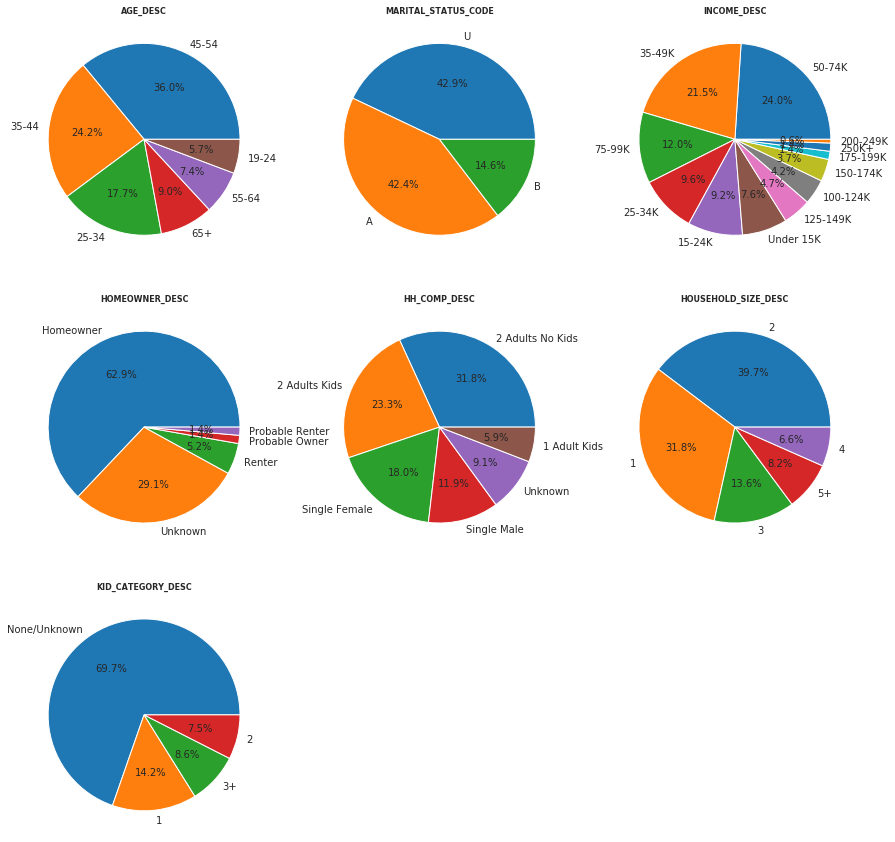

In [26]:
pie_categorical(dfs["hh_demographic"].drop("household_key",axis=1))

## Churn Prediction

Let's start working on the _"Churn Prediction"_ problem from here.

Datasets have been examined and found out that it does not contain a column which indicates whether customer(household) is churned or not. Therefore we will have to **define our own churn** definition and move on to the modelling.

Churn rate works well for subscription-based products or ones that have regular 
nature of interactions like Netflix subscription. It’s clear that 
customer has churned at the moment when he cancels or misses the next planned payment. 

When we know which customers have churned we can ask them for reasons and 
prioritize fixes for them. But for not regular, transactional products churn 
rate is hard to measure since we don’t know which customers are churned and 
which are dormant.

A generally accepted retail churn rate is between five to sevent percent per year. Less than five percent is a great goal, but a churn rate over ten percent is cause for concern. Even as you acquire more customers, your business can't grow unless you have a greater volume of incoming customers than outgoing ones.

Satisfying existing customers is actually more profitable than obtaining new ones. It costs five times more to obtain a new customer than it does to retain an existing customer. Decreasing your churn rate by five percent increases profits up to 125%.

Let's define transactional churn:

*A customer will be considered as churned if not purchased from a store **2 weeks** or more.* 

2 weeks out threshold is chosen as it splits households around 85%/15% No Churn/Churn.



Text(0, 0.5, 'Frequency (Log)')

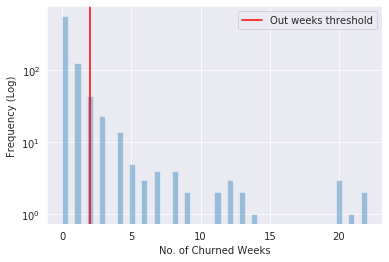

In [32]:
out_weeks_threshold = 2

#weekly customer purchase amount
weekly_purchase = dfs["transaction_data"].groupby(["household_key","WEEK_NO"]).sum()["SALES_VALUE"]
weekly_purchase = weekly_purchase.unstack()

#customer churned by their last 2 week's purchasing behaviour
#go through all households and calculate out weeks
target = []
common_houses = set(dfs["hh_demographic"].household_key) & set(dfs["transaction_data"].household_key)
for house in common_houses:
  target.append(102-weekly_purchase.loc[house].dropna().index[-1])

target = pd.DataFrame(list(zip(common_houses,target)),columns=["household_key","No. of Churned Weeks"])
ax = sns.distplot(target["No. of Churned Weeks"],kde=False)
ax.axvline(x=out_weeks_threshold,c="red",label="Out weeks threshold")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Frequency (Log)")

Now lets generate our target variable for modelling: 
* Churned -> True
* Not Churned -> False

In [0]:
target["isChurned"] = target["No. of Churned Weeks"]>=out_weeks_threshold
target.drop("No. of Churned Weeks",axis=1,inplace=True)

Let's see how households split with the defined churn:

Text(0.5, 1.0, 'Churn Variable Distribution')

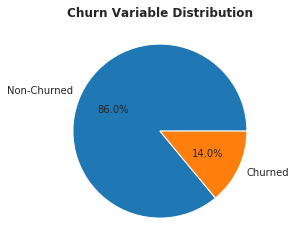

In [35]:
target.isChurned.value_counts().plot(kind="pie",autopct="%.1f%%",labels=["Non-Churned","Churned"])
plt.ylabel("")
plt.title("Churn Variable Distribution",fontweight="bold")

### Feature engineering

Let's generate some features from the _"Campaign Table"_, _"*Transaction Data*"_ and _"Coupon Redempt"_ tables to be used in the churn prediction model:


**Feature 1**: List of campaigns received by each household:

In [0]:
household_per_campaign = dfs["campaign_table"].groupby("CAMPAIGN")["household_key"].apply(list)
total_campaigns = len(dfs["campaign_table"].CAMPAIGN.unique())
df_camp = pd.DataFrame(np.full((total_households,total_campaigns),0),columns=["Camp_"+str(i) for i in range(1,total_campaigns+1)],index=range(1,total_households+1))
for camp in household_per_campaign.index:
    df_camp.loc[household_per_campaign[camp],"Camp_"+str(camp)] = 1

df_camp["household_key"] = df_camp.index

**Feature 2**: Total number of received campaigns per household:

In [0]:
temp = dfs["campaign_table"].household_key.value_counts().sort_index()
no_of_received_campaigns = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","no_of_received_campaigns"])

Lets see if the "number" of campaigns being received affects a household's purchase behaviour.

The correlation between the number of campaigns received by a household and their total purchase amount is visualised in a scatter plot below. Linear line in the graph shows the regression model fitted to the scattered data. One can say the aforementioned variables are **linearly related**.

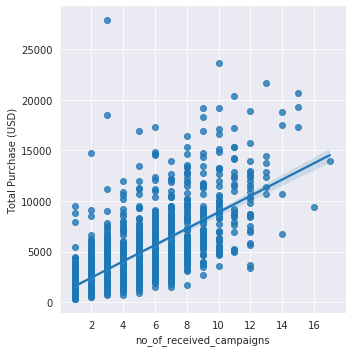

In [38]:
no_of_received_campaigns_vs_sumsales = pd.merge(no_of_received_campaigns,purc_per_cust,on="household_key")
sns.lmplot(x="no_of_received_campaigns",y="Total Purchase (USD)",data=no_of_received_campaigns_vs_sumsales)

In [39]:
no_of_received_campaigns_vs_sumsales.drop("household_key",axis=1).corr()

,no_of_received_campaigns,Total Purchase (USD)
no_of_received_campaigns,1.000000,0.704409
Total Purchase (USD),0.704409,1.000000


The scatter plot and the correlation value above (71%) indicates that the total purchase amount of a household is positively correlated to the number of campaigns received by them.

**Feature 3**: List of campaigns resulted in coupon redemption:

In [0]:
temp = dfs["coupon_redempt"].groupby("household_key")["CAMPAIGN"].apply(list)
rede_camp_history_per_household = pd.DataFrame(list(zip(temp.index,temp.values)),columns=["household_key","redeemed_CAMPAIGN_list"])

**Feature 4**: The number of redemptions made by each household:

In [0]:
temp = dfs["coupon_redempt"].household_key.value_counts().sort_index()
no_of_rede_per_household = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","no_of_redeems"])

**Feature 5**: Most Frequent Campaign Type (A,B,C) received by each household:

In [0]:
camp_list = dfs["campaign_table"].groupby("household_key")["DESCRIPTION"].apply(list)
most_freq_type = pd.DataFrame(list(zip(camp_list.index,[pd.Series(i).value_counts().idxmax() for i in camp_list])),columns=["household_key","most_freq_camp_type"])

**Feature 6**: Top 20 stores with high number of households which have more high out weeks:


In [0]:
store_per_house = dfs["transaction_data"].groupby("household_key")["STORE_ID"].apply(list).apply(np.unique)

churn_houses = set(target.household_key[target.isChurned == True].sort_values().values) & set(dfs["hh_demographic"].household_key.unique())
churn_stores = []
for i in churn_houses:
  churn_stores.extend(store_per_house[i])

churn_stores = pd.Series(churn_stores).value_counts()/len(churn_houses)

df_store = dfs["transaction_data"].groupby(["STORE_ID","household_key"]).count()["BASKET_ID"].unstack("STORE_ID")
df_store.replace(np.nan,0,inplace=True)
df_store[df_store>0] = 1

#select the top stores with high number of churners
df_store = df_store.loc[:,churn_stores.index[:20]]
df_store.columns=["Store_"+str(i) for i in df_store.columns]

**Feature 7**: Amount of purchase of a household within two years:


In [0]:
purc_per_cust = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])

### Last touches on the dataset

Generate the final dataframe to be used for predictive modelling

In [0]:
data = pd.merge(dfs["hh_demographic"],df_camp,on="household_key",how="left")
data = pd.merge(data,no_of_received_campaigns,on="household_key",how="left")
data = pd.merge(data,df_store,on="household_key",how="left")
data = pd.merge(data,no_of_rede_per_household,on="household_key",how="left")
data = pd.merge(data,most_freq_type,on="household_key",how="left")
data = pd.merge(data,purc_per_cust,on="household_key",how="left")
data = pd.merge(data,target,on="household_key",how="left")

In [73]:
data.shape

(801, 92)

Now we have 91 features and a target variable in the final dataframe

In [46]:
data.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,Camp_1,Camp_2,Camp_3,Camp_4,Camp_5,Camp_6,Camp_7,Camp_8,Camp_9,Camp_10,Camp_11,Camp_12,Camp_13,Camp_14,Camp_15,Camp_16,Camp_17,Camp_18,Camp_19,Camp_20,Camp_21,Camp_22,Camp_23,Camp_24,Camp_25,Camp_26,Camp_27,Camp_28,Camp_29,Camp_30,no_of_received_campaigns,Store_450,Store_318,Store_404,Store_289,Store_31582,Store_298,Store_372,Store_412,Store_381,Store_335,Store_380,Store_343,Store_321,Store_421,Store_424,Store_402,Store_375,Store_292,Store_433,Store_367,no_of_redeems,most_freq_camp_type,Total Purchase (USD),isChurned
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,TypeB,4330.16,False
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,TypeB,3400.05,False
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,TypeB,5534.97,False
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,TypeB,13190.92,False
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,TypeA,1512.02,True


Change NaN or None/Unknown values to zero for the columns of "number of received campaigns", "kid category" and the "number of redeems"

In [0]:
data.no_of_received_campaigns.replace(np.nan,0,inplace=True)
data.no_of_received_campaigns = data.no_of_received_campaigns.astype(int)
data.no_of_redeems.replace(np.nan,0,inplace=True)

Change other object type elements in the columns to integer for modeling purpose

In [0]:
data.KID_CATEGORY_DESC.replace(["None/Unknown","3+"],[0,3],inplace=True)
data.KID_CATEGORY_DESC = data.KID_CATEGORY_DESC.astype(int)
data.HOUSEHOLD_SIZE_DESC.replace("5+",5,inplace=True)
data.HOUSEHOLD_SIZE_DESC = data.HOUSEHOLD_SIZE_DESC.astype(int)
data["Total Purchase (USD)"] = data["Total Purchase (USD)"].astype(int)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 63 columns):
AGE_DESC                    801 non-null object
MARITAL_STATUS_CODE         801 non-null object
INCOME_DESC                 801 non-null object
HOMEOWNER_DESC              801 non-null object
HH_COMP_DESC                801 non-null object
HOUSEHOLD_SIZE_DESC         801 non-null int64
KID_CATEGORY_DESC           801 non-null int64
household_key               801 non-null int64
Camp_1                      801 non-null int64
Camp_2                      801 non-null int64
Camp_3                      801 non-null int64
Camp_4                      801 non-null int64
Camp_5                      801 non-null int64
Camp_6                      801 non-null int64
Camp_7                      801 non-null int64
Camp_8                      801 non-null int64
Camp_9                      801 non-null int64
Camp_10                     801 non-null int64
Camp_11                     801 non-null int

Household_key is the ID of a household, therefore will not be used in the modelling. The rest of the data will be used.


In [50]:
data.dtypes.value_counts()

int64      35
float64    21
object      6
bool        1
dtype: int64

Let's see how our features interact with the target variable. Start with the _"**Age**"_ variable:

* Households with the **age of 55-64** tend to churn less then the rest of other age groups
* No monotonic increase or decrease observed with age


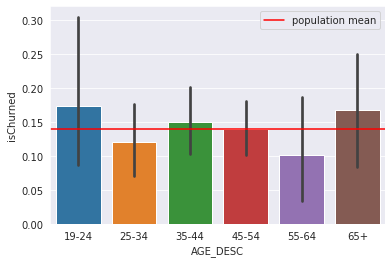

In [51]:
ax = sns.barplot(x="AGE_DESC",y="isChurned",data=data,order=["19-24","25-34","35-44","45-54","55-64","65+"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Marital Status** vs Churn rate:
* Married couples (Group A) tend to churn more compared to singles (Group B)
* Unknown (Group U) households increase the chun rate of the population

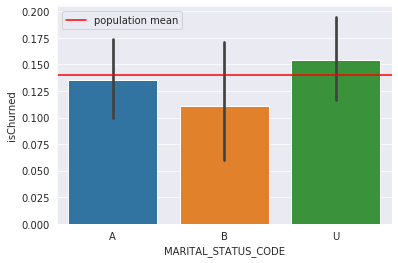

In [52]:
ax = sns.barplot(x="MARITAL_STATUS_CODE",y="isChurned",data=data,order=["A","B","U"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Income** vs Churn Rate:
* No monotonic increase or decrease observed over the income groups
* However as seen in the barchart below, no churn was observed when a household's income reaches to 175K and more (27 samples out of 801 households)

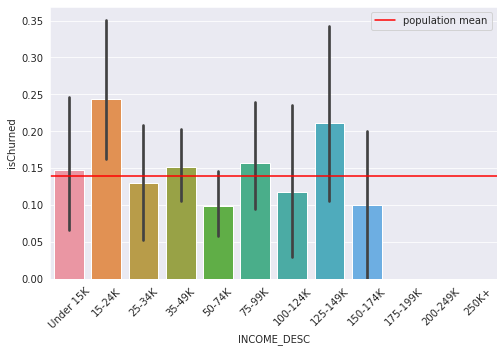

In [53]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="INCOME_DESC",y="isChurned",data=data,
                 order=["Under 15K","15-24K","25-34K","35-49K","50-74K","75-99K","100-124K","125-149K","150-174K","175-199K","200-249K","250K+"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Home Ownership** vs Churn Rate:
* No significant differences between owners and renters

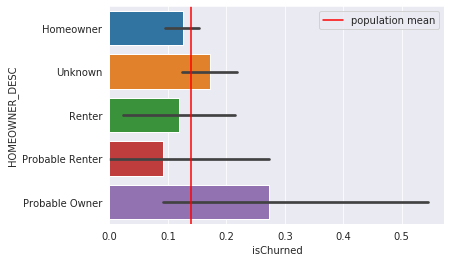

In [54]:
ax = sns.barplot(y="HOMEOWNER_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Number of Redeems** vs Churn Rate:

Lets group our data based on household's number of redeems. We will use pandas.cut which groups the number of redeems into the bins. Graph below separates 0 redeemers, redeemed once and the final group redeemed more than once:
* Churn rate decreases as the number of redeems increase

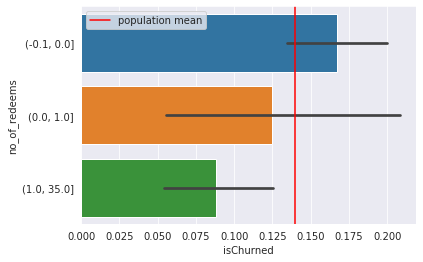

In [82]:
ax = sns.barplot(y=pd.cut(data.no_of_redeems,bins=[-0.1,0,1,35],duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

Churn rate vs **Number of campaigns received by a household**

* Churn rate decreases as the number of campaigns received by a household increases

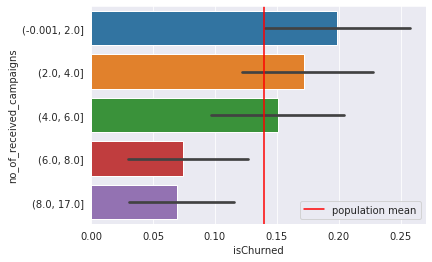

In [56]:
ax = sns.barplot(y=pd.qcut(data.no_of_received_campaigns,5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

Not very clear, however churn rate tends to decrease when **children starts to appear** in households

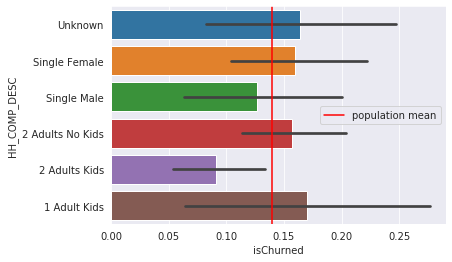

In [57]:
ax = sns.barplot(y="HH_COMP_DESC",x="isChurned",data=data,orient="h",order=['Unknown','Single Female','Single Male','2 Adults No Kids','2 Adults Kids','1 Adult Kids'])
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

Churn rate tends to decrease as the number of **family members** increases

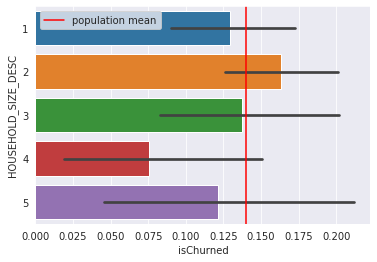

In [58]:
ax = sns.barplot(y="HOUSEHOLD_SIZE_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Campaign Type** vs Churn rate:

* TypeC campaign fails as all households which was approached with campaign C are churned. However note that it has extremely lower sample size (1% of all population)
* TypeB is the most successful one with the lowest churn rate

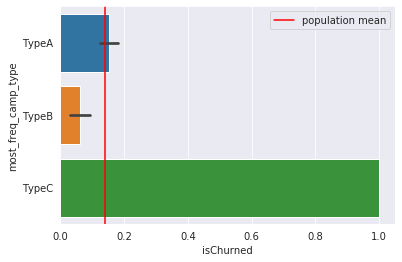

In [59]:
ax = sns.barplot(y="most_freq_camp_type",x="isChurned",data=data,orient="h",order=['TypeA','TypeB','TypeC'])
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()

**Total purchase of a household** vs Churn rate:
* Total purchase amount of a customer is a clear separator, expected to perform well as a feature in the churn prediction model
* Churn rate decreases as total amount of purchase of a household (within 2 years) increases


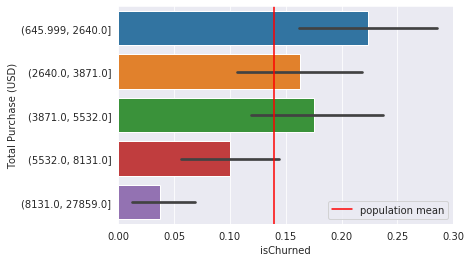

In [62]:
ax = sns.barplot(y=pd.qcut(data["Total Purchase (USD)"],5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()


Correlation between **Campaign Number** and the Target (isChurned) are calculated and displayed in the barchart below:
* Campaign 25 as a feature expected to be performing well in the model as it has the highest correlation with the target variable

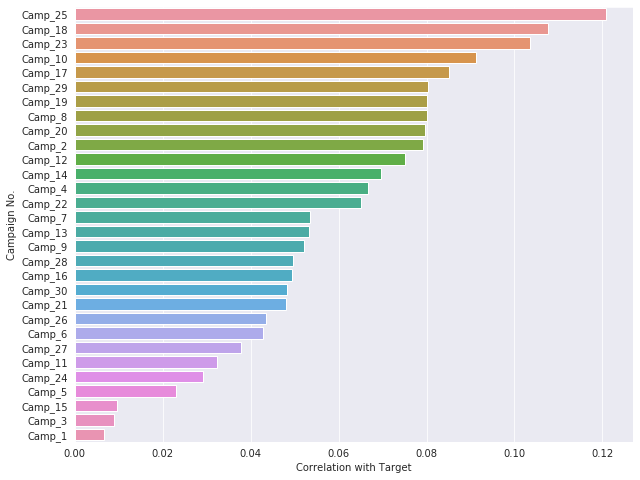

In [60]:
corrs = abs(data[["Camp_"+str(i) if i<31 else "isChurned" for i in range(1,32)]].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Campaign No.","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,8))
sns.barplot(y="Campaign No.",x="Correlation with Target",data = corrs,orient="h")

Correlation between the **stores** with high number of churner customers and the Target (isChurned) are calculated and displayed in the barchart below:

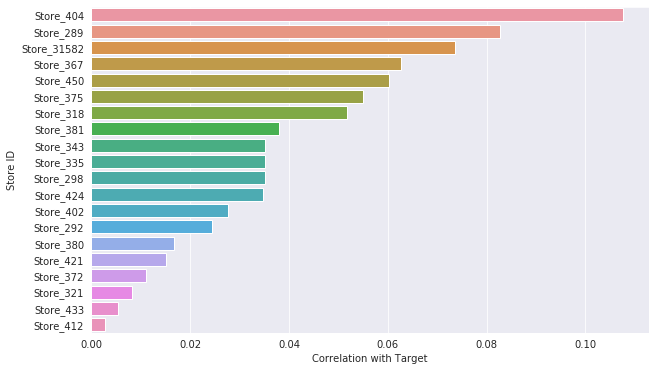

In [61]:
cols =list(df_store.columns)
cols.extend(["isChurned"])
corrs = abs(data[cols].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Store ID","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,6))
sns.barplot(y="Store ID",x="Correlation with Target",data = corrs,orient="h")

### ML Model Training & Testing

In this section we will train a Machine Learning model with the training data. The machine learning model is chosen as **XGBoost** (Extreme Gradient Boosting) as they are known to be performing well with imbalanced datasets like ours.

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#one hot encoding categorical data for modelling
encoded = pd.get_dummies(data[data.columns[data.dtypes==object]])
data_encoded = pd.concat([encoded, data[data.columns[data.dtypes != object]]],axis=1)

#Features (X) and the target (y)
X = data_encoded.drop("isChurned",axis=1)
y = data_encoded.isChurned

#lets start with the default hyperparameters and hold-out mechanism for train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

#XGBoost
xgb_mdl = XGBClassifier().fit(X_train.values,y_train.values)
xgb_mdl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

We first transformed our categorical variables using one-hot encoding algorithm (get_dummies) to be able to use in our classifier. Then separated the data into train and test 75%/25%. Then generated an XGBoost classifier with it's default parameters and trained it with the training set. 

Now let's test our trained classifier with test data:

Train Data Classification Report:

              precision    recall  f1-score   support

       False       0.89      1.00      0.94       511
        True       0.96      0.29      0.45        89

    accuracy                           0.89       600
   macro avg       0.93      0.65      0.69       600
weighted avg       0.90      0.89      0.87       600

Test Data Classification Report:

              precision    recall  f1-score   support

       False       0.89      0.99      0.94       178
        True       0.00      0.00      0.00        23

    accuracy                           0.88       201
   macro avg       0.44      0.50      0.47       201
weighted avg       0.78      0.88      0.83       201



[Text(33.0, 0.5, 'real values'),
 Text(0.5, 15.0, 'predicted values'),
 Text(0.5, 1, 'Confusion Matrix')]

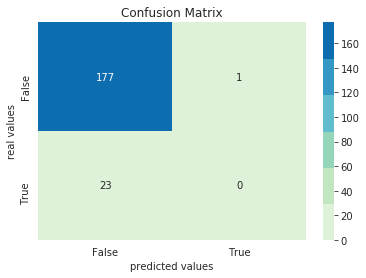

In [64]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score

#XGBoost
y_pred_train = xgb_mdl.predict(X_train.values)
y_pred = xgb_mdl.predict(X_test.values)

print("Train Data Classification Report:\n")
print(classification_report(y_train,y_pred_train))

print("Test Data Classification Report:\n")
print(classification_report(y_test,y_pred))

#generate a confusion matrix to visualise precision, recall, misclassification and false alarms
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = list(set(y)), columns = list(set(y)))

#visualise the confusion matrix in the heatmap form
plt.figure()
sns.heatmap(cm, annot = True, fmt="d",
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix')

In [65]:
roc_auc_score(y_test,y_pred)
# average_precision_score(y_test,y_pred)

0.49719101123595505

Even though accuracy for the test set is 88% it is misleading as our target variable is **skewed** towards not churned (86% are not churned). Even a very basic model which selects majority class all times would score 86% accuracy.

Therefore we will have to focus on how well our model performs on the minority class (churned households). On the test set we have 201 samples only 23 of them being churned. Our model could not manage to detect any of them, therefore test set recall has come out as 0%. This is the part we need to aim to increase.

Now lets try to enhance our model by optimising hyperparameters by using "**Randomised Search**" with "**Cross-Validation**".

We need to determine the evaluation criteria (scorer) to be optimised for the Randomised Search. Lets see the available scorers:
* **average precision**, **balanced accuracy**, **roc_auc**, **f1** are the scorers which are commonly used for imbalanced dataset classifications as they handle situation well as compared to other metrics

In [66]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [67]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

#handle class imbalance problem by undersampling (not used)
# no_churn_down_sampled = data_encoded[data_encoded.isChurned == False].sample(sum(data_encoded.isChurned))
# data_encoded_balanced = pd.concat([no_churn_down_sampled,data_encoded[data_encoded.isChurned]])
#shuffle the dataset to avoiding sampling biases
# data = data_encoded_balanced.sample(frac=1)

#shuffle the dataset to avoiding sampling biases
data = data_encoded.sample(frac=1)
X = data.drop("isChurned",axis=1)
y = data.isChurned

#generate an XGB classifier
mdl = XGBClassifier()

#parameter ranges
param_list = {
    'silent': [False],
    'max_depth': range(2,51),
    'learning_rate': [0.001, 0.01, 0.1, 0.15],
    'subsample': np.arange(0,1.1,.1),
    'colsample_bytree': np.arange(0,1.1,.1),
    'colsample_bylevel': np.arange(0,1.1,.1),
    'min_child_weight': [0.5, 0.7, 1.0, 2.0, 3.0],
    'gamma': [0, 0.25, 0.5, 0.75, 0.9, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0],
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'scale_pos_weight': [1, 1.5, 2, 6, 6.1, 6.3, 6.5, 8],
    'max_delta_step': [1, 2, 3, 5, 10]
}

kfold = 5
cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=10)

#Randomized Search
# cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="roc_auc",n_jobs=-1).fit(X.values,y.values)
cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="balanced_accuracy",n_jobs=-1).fit(X.values,y.values)
# cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="average_precision",n_jobs=-1).fit(X.values,y.values)

#use the best estimator after the hyperparameter optimisation
mdl_best = cv.best_estimator_

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2540 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3834 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.1min finished


Hyperparameter optimisation is completed. Now lets train and test the XGBoost Classifier with the optimised hyperparameters 

In [68]:
cv.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.01,
 'max_delta_step': 5,
 'max_depth': 2,
 'min_child_weight': 2.0,
 'n_estimators': 50,
 'reg_lambda': 100.0,
 'scale_pos_weight': 6,
 'silent': False,
 'subsample': 1.0}

_**scale_pos_weight**_ is the parameter used for biasing (weighing more) of the minority class samples. The higher the value the more bias towards minority class. In our dataset, the ratio between majority class samples and the minority class is **6.15** which coheres with this parameter (optimised value came out as 6).

Lets test our optimised model with the data:

In [69]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=20)
scores = cross_validate(mdl_best,X.values,y.values,cv=cv_strat,verbose=3,n_jobs=-1,return_train_score=True,
                        scoring={"roc_auc":"roc_auc",
                                 "recall":"recall",
                                 "precision":"precision",
                                 "accuracy":"accuracy",
                                 "balanced_accuracy":"balanced_accuracy",
                                 "average_precision":"average_precision"}) 

pd.DataFrame(pd.DataFrame(scores).mean(),columns=["Score"]).drop(["fit_time","score_time"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


,Score
test_roc_auc,0.624930
train_roc_auc,0.741549
test_recall,0.699941
train_recall,0.804433
test_precision,0.184466
train_precision,0.212835
test_accuracy,0.525773
train_accuracy,0.555137
test_balanced_accuracy,0.598740
train_balanced_accuracy,0.659518


Even though getting lower accuracy in total, now we are getting much better results for the minority class as recall and ROC AUC (receiver operating characteristics, area under curve) increased significantly.

The score table above gives all metric results for both test and train sets. Train and test results are close which is an indication that our model **did not overfit**.

Let's check which parameters were more important to separate churners/non churners. The barchart below list the features ordered by their importance values for the XGB Classifier. 

As expected, "**Total Purchase**", "**Number of Received Campaigns**", "**Campaign no. 25**", and "**Numer of redeems**" features are the most important features for the classifier. As we recall from feature engineering section, these features were either a good separator or highly correlated to the target variable.

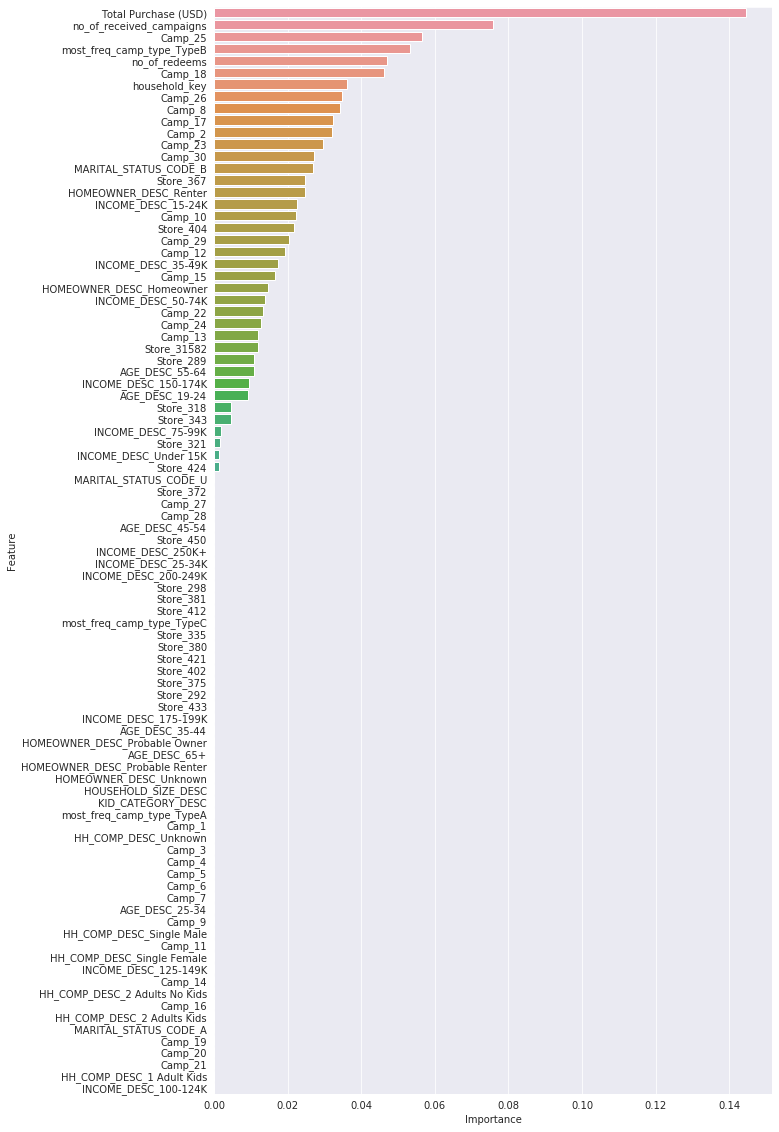

In [72]:
feat_imp = pd.DataFrame(list(zip(data.columns,mdl_best.feature_importances_)),columns=["Feature","Importance"]).sort_values(by="Importance",ascending=False)
fig_store = plt.figure(figsize=(10,20))
sns.barplot(y="Feature",x="Importance",data = feat_imp,orient="h")